#  BANK-MARKETING CAMPAIGN 

This dataset is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be (or not) subscribed. 
Classification goal is to predict if the client will subscribe a term deposit (variable y).

###   Attribute information:
###  Bank client data:
1. age(numeric)
2. job : type of job (categorical)
3. Marital : marital status (categorical)
4. education : (categorical)
5. default : has credit in default(binary)
6. balance : average yearly balance, in euros (numeric) 
7. housing : has housing loan (binary)
8. loan : has personal loan (binary)

###  Related with the last contact of the current campaign:
9. contact : contact communication type (categorical) 
10. day : last contact day of the month (numeric)
11. month : last contact month of year (categorical)
12. duration : last contact duration, in seconds (numeric)

###  Other attributes:
13. campaign : number of contacts performed during this campaign and for this client (numeric, includes last contact)
14. pdays : number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
15. previous : number of contacts performed before this campaign and for this client (numeric)
16. poutcome : outcome of the previous marketing campaign (categorical)
17. y (output variable) : has the client subscribed a term deposit? (binary)

In [2]:
# Import necessary libraries

import warnings
%matplotlib inline
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
from sklearn import tree
from scipy.stats import randint 
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,roc_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import precision_score, recall_score,f1_score,roc_auc_score,accuracy_score,classification_report

In [16]:
# Load the dataset

df = pd.read_csv('bank-full.csv',sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


#  Exploratory Data Analysis

In [17]:
# df.shape

df.shape

(45211, 17)

In [18]:
# Check the null values

df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [360]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
y            45211 non-null object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [361]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [6]:
int_cols = [cols for cols in df if df[cols].dtypes=='int64']
cat_cols = [cols for cols in df if df[cols].dtypes=='O'][:-1]
print('Categorical Columns   :',cat_cols)
print('Numerical Columns     :',int_cols)

Categorical Columns   : ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
Numerical Columns     : ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


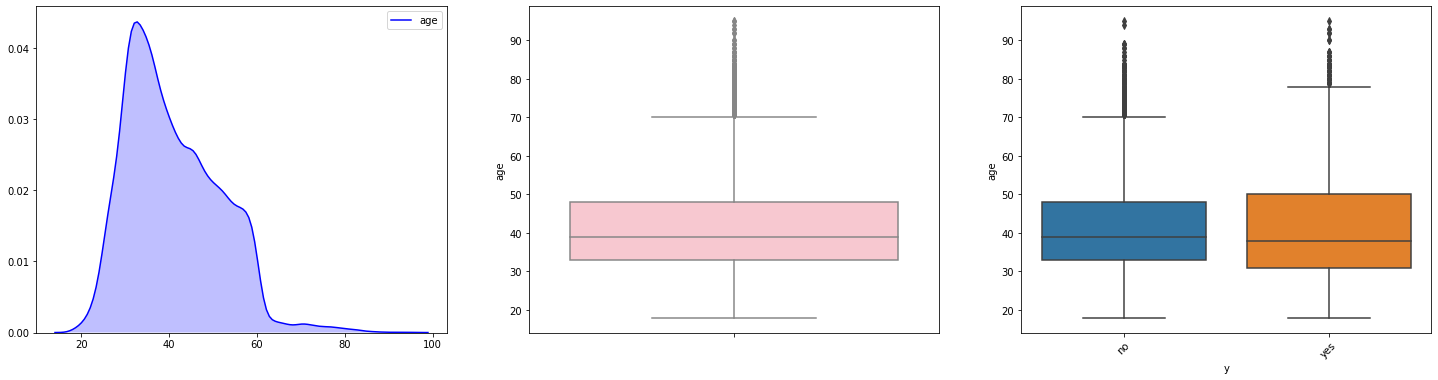

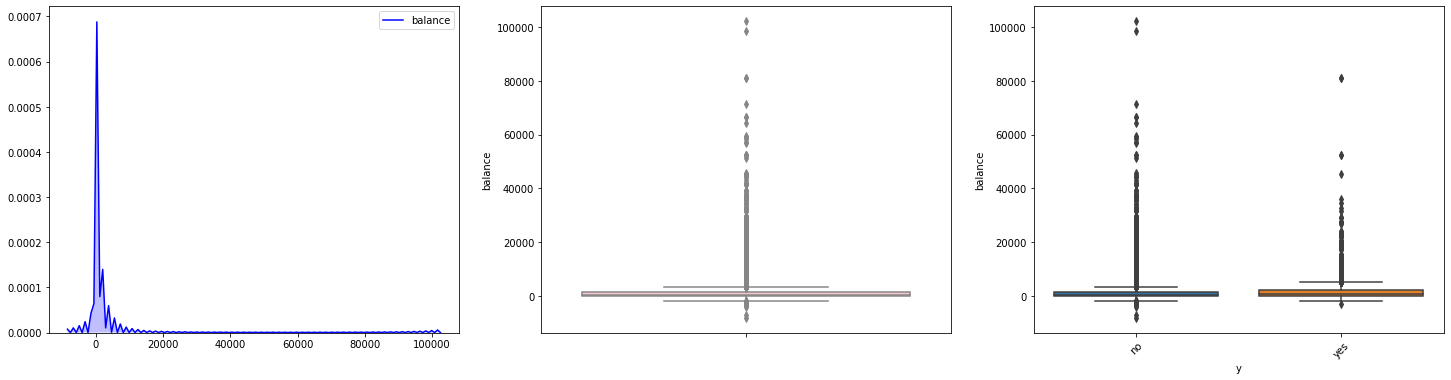

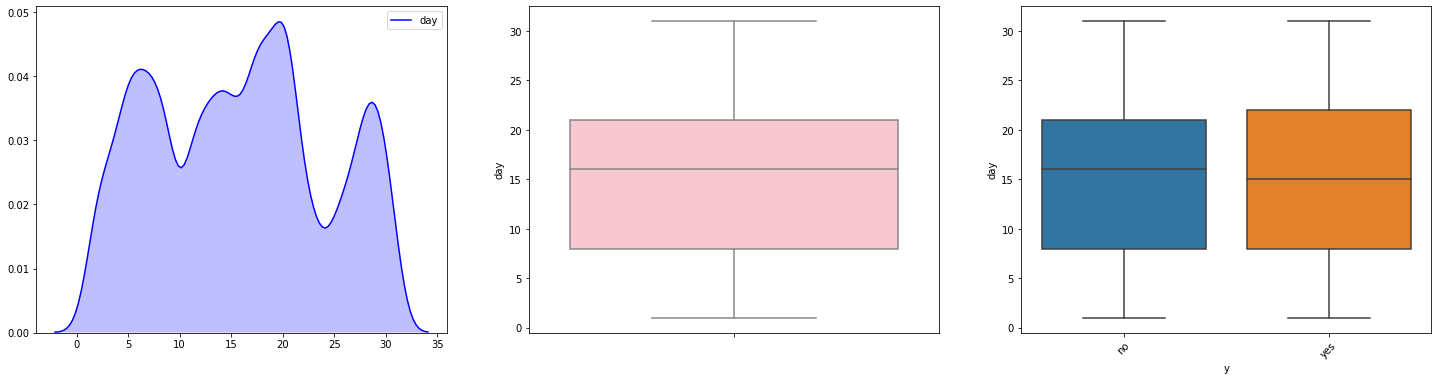

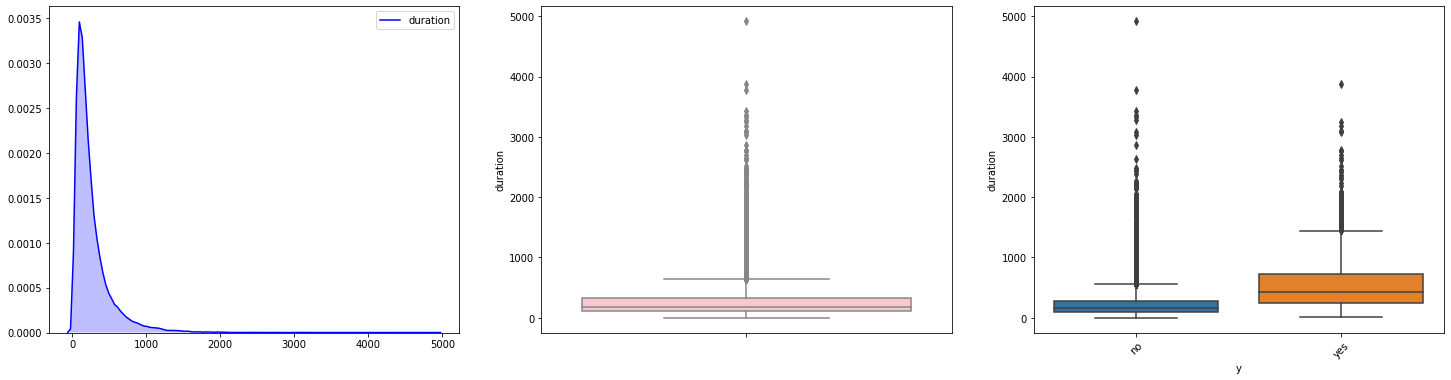

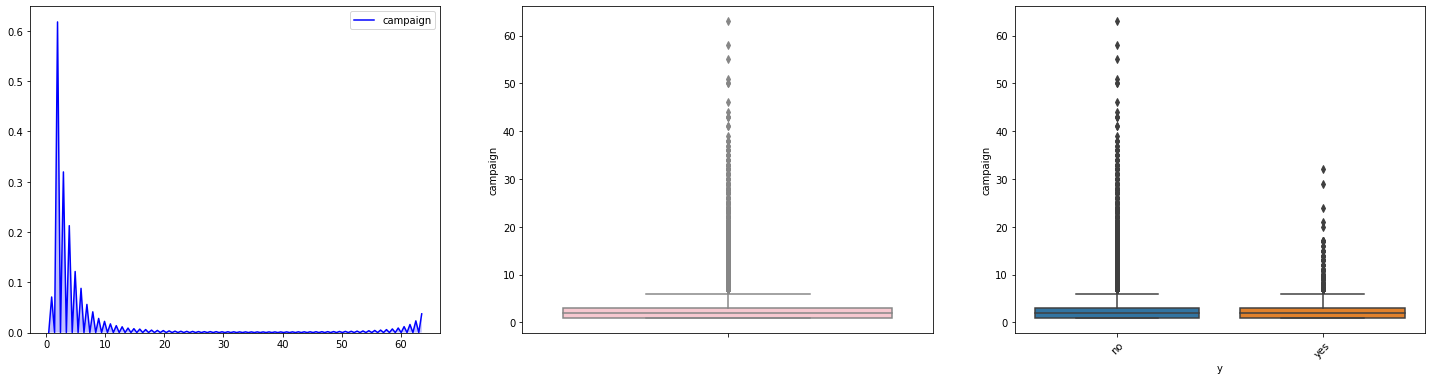

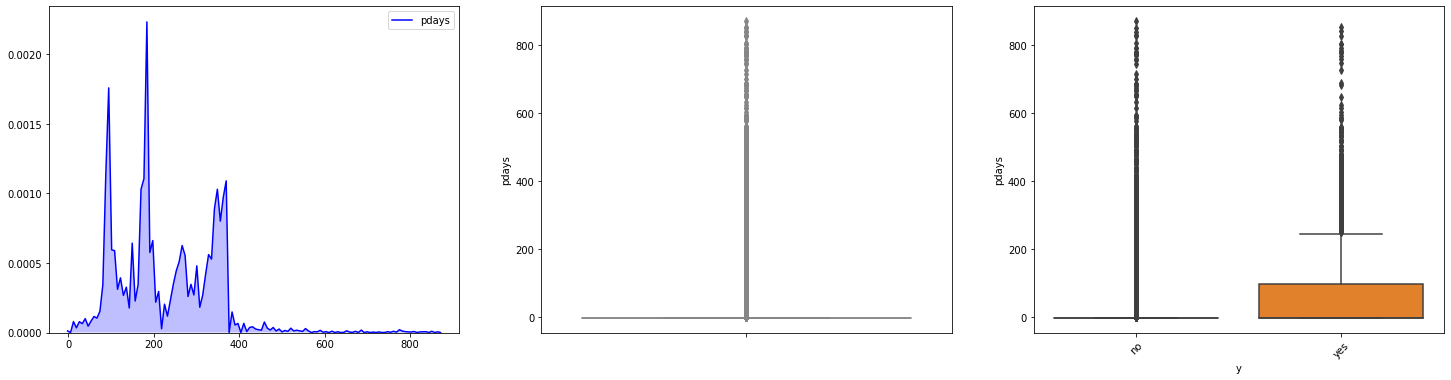

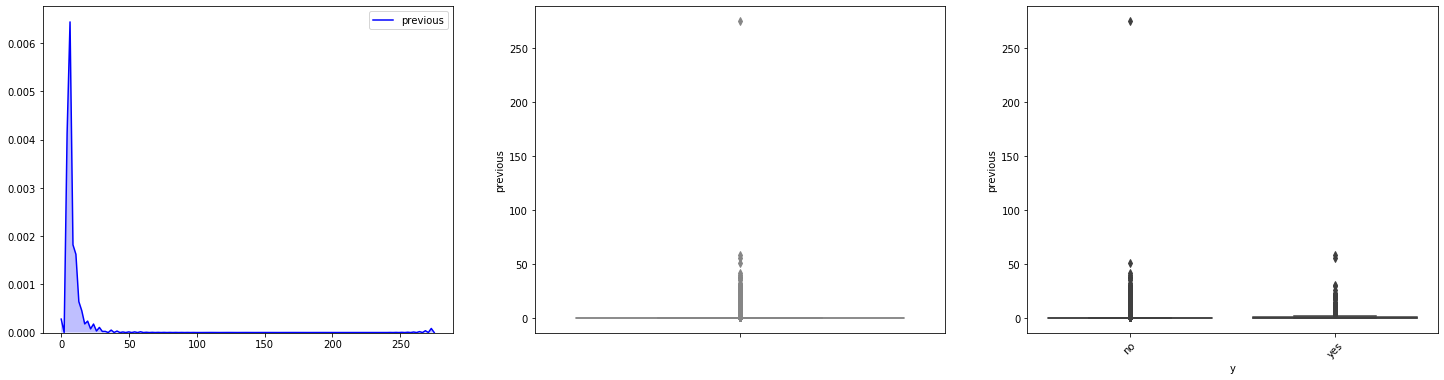

In [363]:
for cols in int_cols:
    plt.figure(figsize=(25,6))
    plt.subplot(131)
    sns.kdeplot(df[cols],shade=True,color='b')
    
    plt.subplot(132)
    sns.boxplot(y=df[cols],color='pink')
    
    plt.subplot(133)
    sns.boxplot(x=df['y'],y=df[cols])
    plt.xticks(rotation=45)
    
    plt.show()

Observations:
- There's a right skew in the age column, which means that the age of customers is generally around 20-40 which have been targeted majorly for the campaign. People who have subscribed and not subscribed have an almost similar boxplot distribution.
- The average yearly balance is righly skewed, which shows the average balance for the accounts is generally lower, but we can clearly see in the boxplot distrbution that people who subscribed to the campaign have comparatively more yearly balance and there are lesser outliers compared to those who don't.
- Duration is right-skewed indicating call duration has been low in general. Also, the boxplots show a major difference between duration of people who subscribed as opposed to those who dint. People who subscribed have a higher call duration which makes sense since they were the ones who had an actual conversation.
- There is a large number of outliers in boxplots of people who did not subscribe, which implies there were many people who did not maybe receive calls repeatedly.
- Most of the clients that subscribed were the ones who had comparatively been contacted recently for some other related campaigns. 

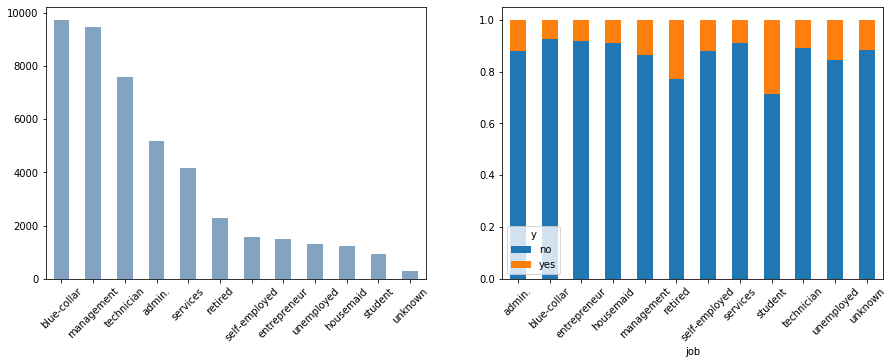

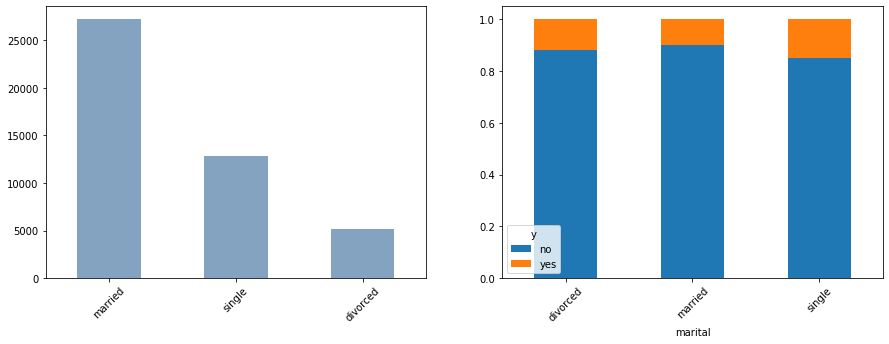

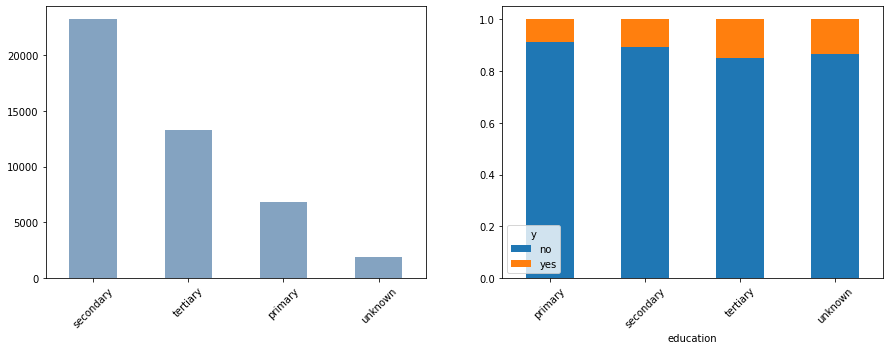

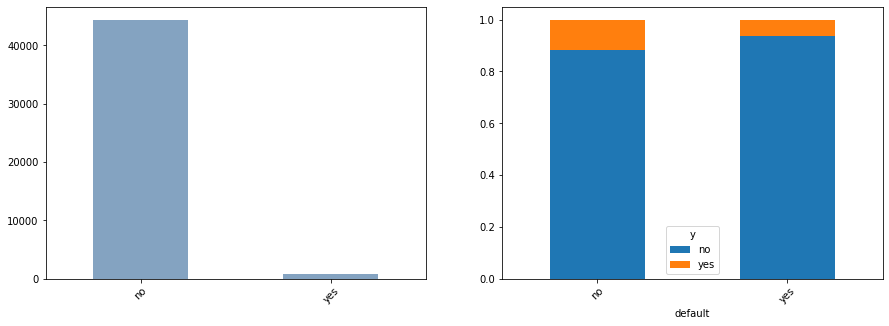

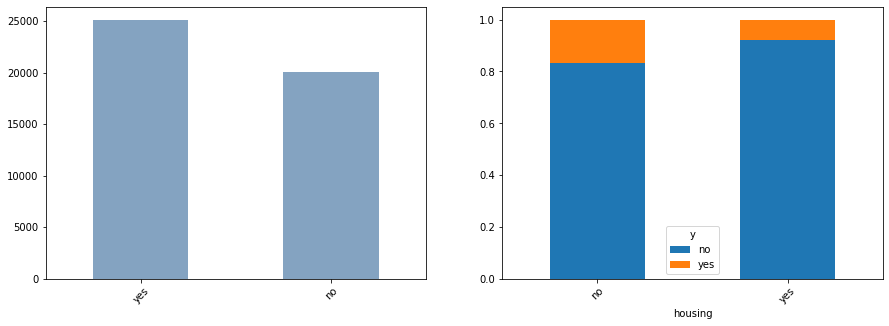

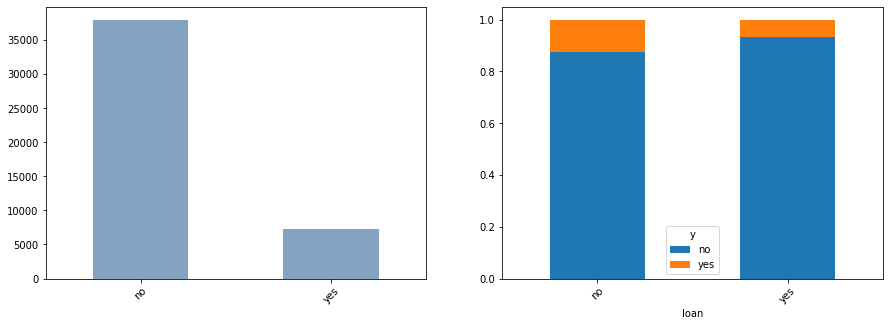

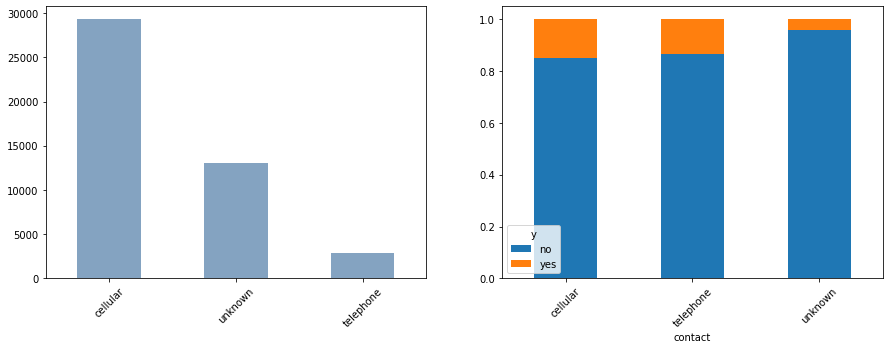

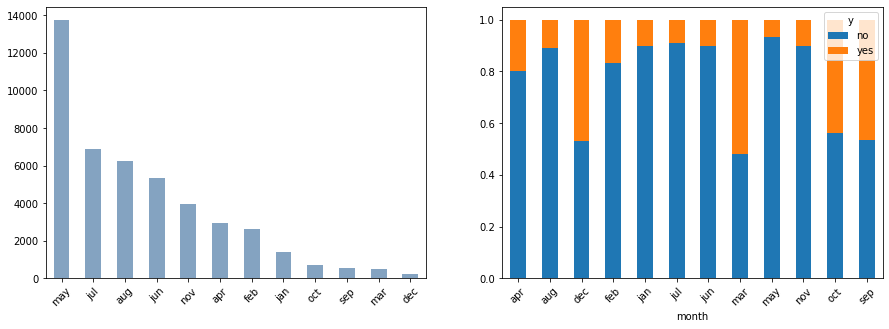

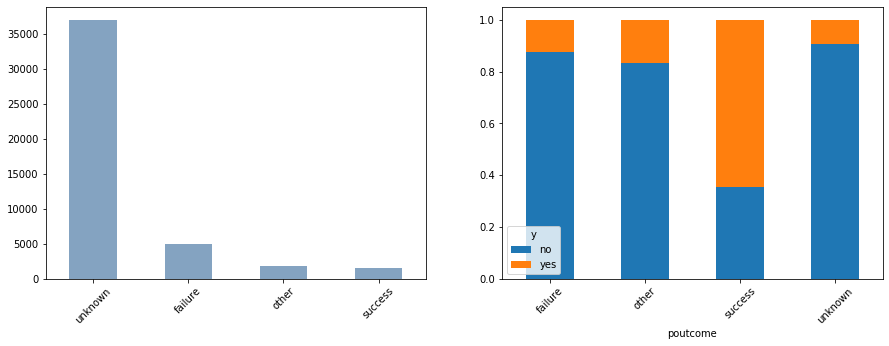

In [364]:
for cols in cat_cols:
    plt.figure(figsize=(15,5))

    plt.subplot(121)
    df[cols].value_counts().sort_values(ascending=False).plot.bar(color=(0.2, 0.4, 0.6, 0.6))
    plt.xticks(rotation=45)
    
    ax=plt.subplot(122)
    Col = pd.crosstab(df[cols],df['y'])
    Col.div(Col.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True,ax=ax)
    plt.xticks(rotation=45)
    
    plt.show()

Observations:
- Highest no of calls were made to white-collared, management, technicians and admin employees. Fewer calls were made to retired and students, but there comparative ratio of subscription is more. So, the target audience needs include these categories of people.
- Highest calls were made to the married couples, followed by singles and divorced. But the subscription ratio of married people is the lowest among these 3, so perhaps audience focus should be shifted to the singles and divorced.
- People with secondary education and tertiary education have more number of calls, and the rate of subscription is also good, although tertiary is better than secondary, so probably the calls can be increased for this section. Primary educated audience has lesser conversion, which is in accordance with people contacted.
- Majority target audience is people who do not have credict in default, which makes sense since people who are already indebted are very unlikely to subscribe, which can be seen.
- People who already have a housing loan, have been contacted more, which can be due to the fact that they already satisfy the criteria of availing a loan which means they have good credit or a steady income probably, but the ratio-wise comparative barplot shows that people who do not have a housing loan give better conversions. This maybe because people want to repay the already existing loan before subscribing to a new plan.
- People who do not have any previous personal loans are likely to respond better than the ones who do.
- People have an almost similar response, irrespective of the medium through which contact is made.
- Maximum subscriptions have been in March, december, september and october ratio-wise, and the contacts made in this month have been the lowest, so this needs to be a major area where change is supposed to be implemented.

##  Data Processing

In [365]:
df.skew()

age          0.684818
balance      8.360308
day          0.093079
duration     3.144318
campaign     4.898650
pdays        2.615715
previous    41.846454
dtype: float64

In [366]:
df.min()

age                18
job            admin.
marital      divorced
education     primary
default            no
balance         -8019
housing            no
loan               no
contact      cellular
day                 1
month             apr
duration            0
campaign            1
pdays              -1
previous            0
poutcome      failure
y                  no
dtype: object

In [19]:
# Drop previous column as it has the same information as pdays

df.drop('previous',axis=1,inplace=True)

In [20]:
# Transform and scale data

pt = PowerTransformer(method='yeo-johnson', standardize=True) 
df_scaled = pd.DataFrame(pt.fit_transform(df[['balance','duration','campaign','pdays']]),
                         columns=['balance','duration','campaign','pdays'])

In [21]:
df_scaled.skew()

balance     1.098582
duration    0.018045
campaign    0.230942
pdays       1.645213
dtype: float64

In [22]:
df_scaled.min()

balance    -34.879515
duration    -4.162236
campaign    -1.108191
pdays       -0.472533
dtype: float64

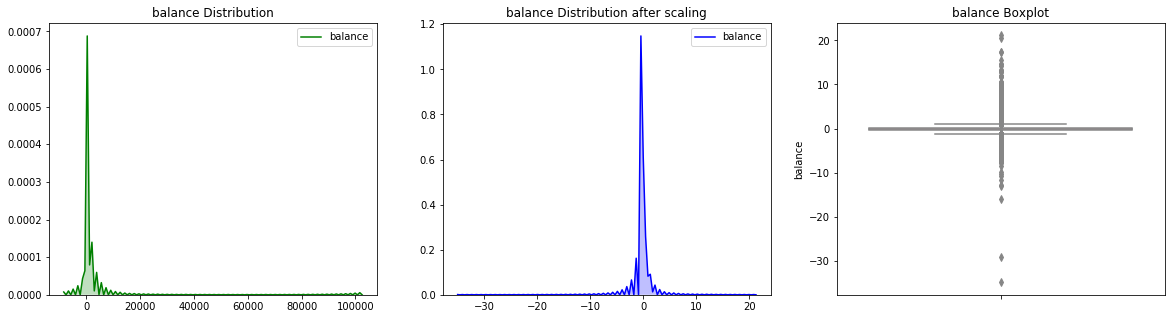

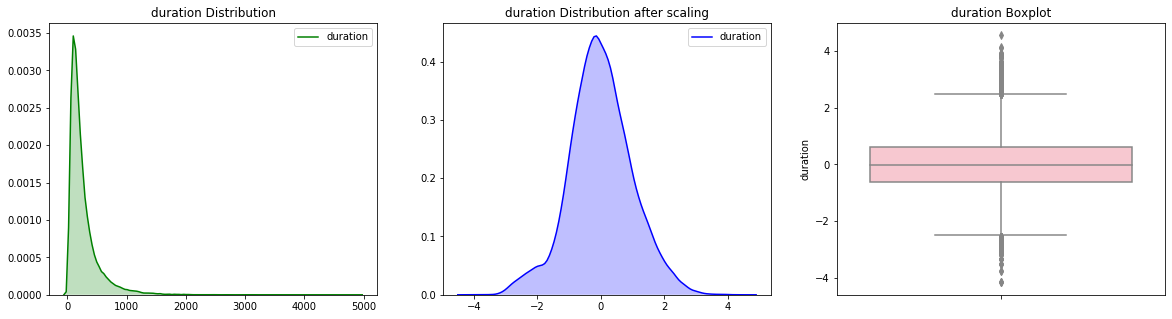

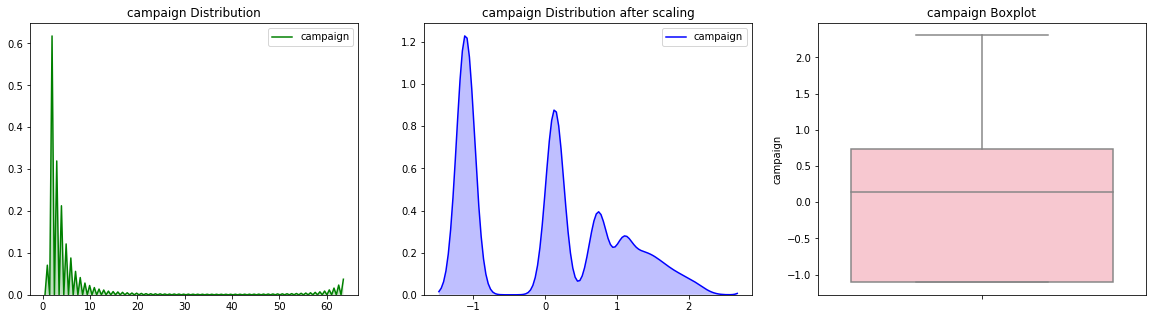

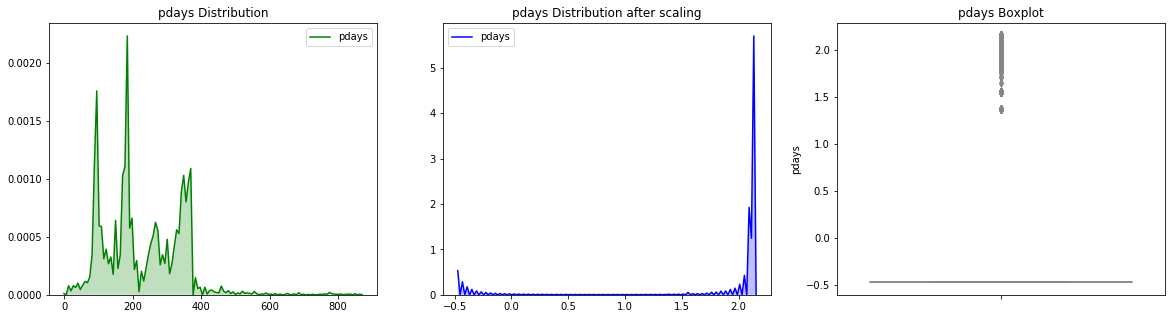

In [11]:
# Plot normalized distributions against the original ones

trans_cols = ['balance','duration','campaign','pdays']
for cols in trans_cols:
    plt.figure(figsize=(20,5))
    
    plt.subplot(131)
    sns.kdeplot(df[cols],color='g',shade=True)
    plt.title(cols+' Distribution')

    plt.subplot(132)
    sns.kdeplot(df_scaled[cols],color='b',shade=True)
    plt.title(cols+' Distribution after scaling')
    
    plt.subplot(133)
    sns.boxplot(y = df_scaled[cols],color='pink')
    plt.title(cols+' Boxplot')
    
    plt.show()

In [23]:
# Conversion to positive scale

df['balance']  = df_scaled['balance']+35
df['duration'] = df_scaled['duration']+5
df['campaign'] = df_scaled['campaign']+2
df['pdays']    = df_scaled['pdays']+1

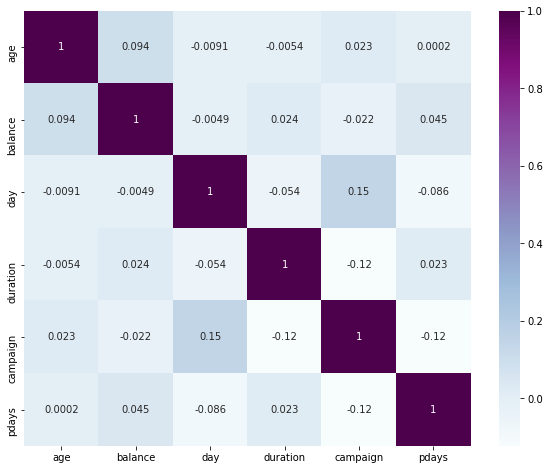

In [24]:
# Heatmap

plt.figure(figsize=(10,8))
sns.heatmap(df.corr(),annot=True,cmap='BuPu')
b,t=plt.ylim()
b+=0.5
t-=0.5
plt.ylim(b,t)
plt.show()

In [25]:
# Remove the unknown columns

for cols in cat_cols:
    print(cols,len(df[df[cols]=='unknown']),round(len(df[df[cols]=='unknown'])/len(df),3))

job 288 0.006
marital 0 0.0
education 1857 0.041
default 0 0.0
housing 0 0.0
loan 0 0.0
contact 13020 0.288
month 0 0.0
poutcome 36959 0.817


In [374]:
df.drop('poutcome',axis=1,inplace=True)

In [375]:
cat_cols = [cols for cols in df if df[cols].dtypes=='O'][:-1]
print('Category Columns :',cat_cols)
for cols in cat_cols:
    df[cols].replace('unknown',df[cols].mode()[0],inplace=True)

Category Columns : ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month']


In [376]:
for cols in cat_cols:
    print(cols,len(df[df[cols]=='unknown']))

job 0
marital 0
education 0
default 0
housing 0
loan 0
contact 0
month 0


#  Model Building

In [26]:
df['y'].replace({'yes':1,'no':0},inplace=True)

In [27]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [28]:
X = pd.get_dummies(X,drop_first=True)

In [29]:
X.head()

,age,balance,day,duration,campaign,pdays,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,58,35.414773,5,5.386077,0.891809,0.527467,0,0,0,1,...,0,0,0,1,0,0,0,0,0,1
1,44,34.589226,5,4.776967,0.891809,0.527467,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,33,34.568878,5,4.076146,0.891809,0.527467,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
3,47,35.197685,5,4.264322,0.891809,0.527467,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,33,34.567881,5,5.072812,0.891809,0.527467,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [30]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=3)

###  Logistic Regression

In [31]:
lr = LogisticRegression()
lr_params = {'penalty':['l1','l2'],'C':[0.001,0.01,0.1,1,10,100,1000]}

grid_lr = GridSearchCV(lr,lr_params)
grid_lr.fit(x_train,y_train)

model_lr = LogisticRegression(**grid_lr.best_params_)
model_lr.fit(x_train,y_train)
lr_y_pred = model_lr.predict(x_test)
lr_y_prob = model_lr.predict_proba(x_test)[:,1]

###  Decision Tree Classifier

In [32]:
dt = DecisionTreeClassifier(random_state=3)
params = {'criterion':['gini','entropy'],'max_depth':[2,4,6,8,10,12],'min_samples_split':[2,4,6,8,10,12],
          'min_samples_leaf':[1,2,4,6,8,10,12]}

grid_dt = GridSearchCV(dt,param_grid=params,cv=3,scoring='roc_auc',return_train_score=True,n_jobs=-1)
grid_dt.fit(x_train,y_train)

model_dt = DecisionTreeClassifier(**grid_dt.best_params_)
model_dt.fit(x_train,y_train)
dt_y_pred = model_dt.predict(x_test)
dt_y_prob = model_dt.predict_proba(x_test)[:,1]

###  Random Forest Classifier

In [33]:
rf = RandomForestClassifier(random_state=3)
rf.fit(x_train,y_train)
rf_y_pred = rf.predict(x_test)
rf_y_prob = rf.predict_proba(x_test)[:,1]

###  XGBoost Classifier

In [34]:
xg = xgb.XGBClassifier(random_state=3)
xg.fit(x_train,y_train)
xg_y_pred = xg.predict(x_test)
xg_y_prob = xg.predict_proba(x_test)[:,1]

##  RESULTS

### Logistic Regression

In [35]:
cm = confusion_matrix(y_test,lr_y_pred)
print('Logistic Regression Results  :')
print(cm)
TN = cm[0][0]
TP = cm[1][1]
FN = cm[1][0]
FP = cm[0][1]
sensitivity = TP/float(TP+FN)
specificity = TN/float(FP+TN)
precision = TP/float(TP+FP)
print('Sensitivity  :',round(sensitivity*100),'%')
print('Specificity  :',round(specificity*100),'%')
print('Precision    :',round(precision*100),'%')
print('Accuracy     :',accuracy_score(y_test,lr_y_pred))
print('Auc score    :',roc_auc_score(y_test,lr_y_prob))
print(classification_report(y_test,lr_y_pred))

Logistic Regression Results  :
[[11714   255]
 [ 1046   549]]
Sensitivity  : 34.0 %
Specificity  : 98.0 %
Precision    : 68.0 %
Accuracy     : 0.9040843409023887
Auc score    : 0.9076461632466946
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     11969
           1       0.68      0.34      0.46      1595

    accuracy                           0.90     13564
   macro avg       0.80      0.66      0.70     13564
weighted avg       0.89      0.90      0.89     13564



###  Decision Tree Classifier

In [36]:
cm = confusion_matrix(y_test,dt_y_pred)
print('Decision Tree Results  :')
print(cm)
TN = cm[0][0]
TP = cm[1][1]
FN = cm[1][0]
FP = cm[0][1]
sensitivity = TP/float(TP+FN)
specificity = TN/float(FP+TN)
precision = TP/float(TP+FP)
print('Sensitivity  :',round(sensitivity*100),'%')
print('Specificity  :',round(specificity*100),'%')
print('Precision    :',round(precision*100),'%')
print('Accuracy     :',accuracy_score(y_test,dt_y_pred))
print('Auc score    :',roc_auc_score(y_test,dt_y_prob))
print(classification_report(y_test,dt_y_pred))

Decision Tree Results  :
[[11658   311]
 [ 1022   573]]
Sensitivity  : 36.0 %
Specificity  : 97.0 %
Precision    : 65.0 %
Accuracy     : 0.9017251548215865
Auc score    : 0.8907156968459012
              precision    recall  f1-score   support

           0       0.92      0.97      0.95     11969
           1       0.65      0.36      0.46      1595

    accuracy                           0.90     13564
   macro avg       0.78      0.67      0.70     13564
weighted avg       0.89      0.90      0.89     13564



###  Random Forest Classifier

In [37]:
cm = confusion_matrix(y_test,rf_y_pred)
print('Random Forest Results  :')
print(cm)
TN = cm[0][0]
TP = cm[1][1]
FN = cm[1][0]
FP = cm[0][1]
sensitivity = TP/float(TP+FN)
specificity = TN/float(FP+TN)
precision = TP/float(TP+FP)
print('Sensitivity  :',round(sensitivity*100),'%')
print('Specificity  :',round(specificity*100),'%')
print('Precision    :',round(precision*100),'%')
print('Accuracy     :',accuracy_score(y_test,rf_y_pred))
print('Auc score    :',roc_auc_score(y_test,rf_y_prob))
print(classification_report(y_test,rf_y_pred))

Random Forest Results  :
[[11638   331]
 [  942   653]]
Sensitivity  : 41.0 %
Specificity  : 97.0 %
Precision    : 66.0 %
Accuracy     : 0.9061486287230905
Auc score    : 0.9305969627389041
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     11969
           1       0.66      0.41      0.51      1595

    accuracy                           0.91     13564
   macro avg       0.79      0.69      0.73     13564
weighted avg       0.89      0.91      0.90     13564



###  XGBoost Classifier

In [38]:
cm = confusion_matrix(y_test,xg_y_pred)
print('XGBoost Classifier Results  :')
print(cm)
TN = cm[0][0]
TP = cm[1][1]
FN = cm[1][0]
FP = cm[0][1]
sensitivity = TP/float(TP+FN)
specificity = TN/float(FP+TN)
precision = TP/float(TP+FP)
print('Sensitivity  :',round(sensitivity*100),'%')
print('Specificity  :',round(specificity*100),'%')
print('Precision    :',round(precision*100),'%')
print('Accuracy     :',accuracy_score(y_test,xg_y_pred))
print('Auc score    :',roc_auc_score(y_test,xg_y_prob))
print(classification_report(y_test,xg_y_pred))

XGBoost Classifier Results  :
[[11532   437]
 [  800   795]]
Sensitivity  : 50.0 %
Specificity  : 96.0 %
Precision    : 65.0 %
Accuracy     : 0.908802713063993
Auc score    : 0.9338890357037812
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     11969
           1       0.65      0.50      0.56      1595

    accuracy                           0.91     13564
   macro avg       0.79      0.73      0.76     13564
weighted avg       0.90      0.91      0.90     13564



##  Comparison of classification models using AUC-ROC Curve

In [39]:
lr_fpr, lr_tpr, lr_threshold = roc_curve(y_test, lr_y_prob)
lr_threshold[0] = lr_threshold[0]-1
dt_fpr, dt_tpr, dt_threshold = roc_curve(y_test, dt_y_prob)
dt_threshold[0] = dt_threshold[0]-1
rf_fpr, rf_tpr, rf_threshold = roc_curve(y_test, rf_y_prob)
rf_threshold[0] = rf_threshold[0]-1
xg_fpr, xg_tpr, xg_threshold = roc_curve(y_test, xg_y_prob)
xg_threshold[0] = xg_threshold[0]-1

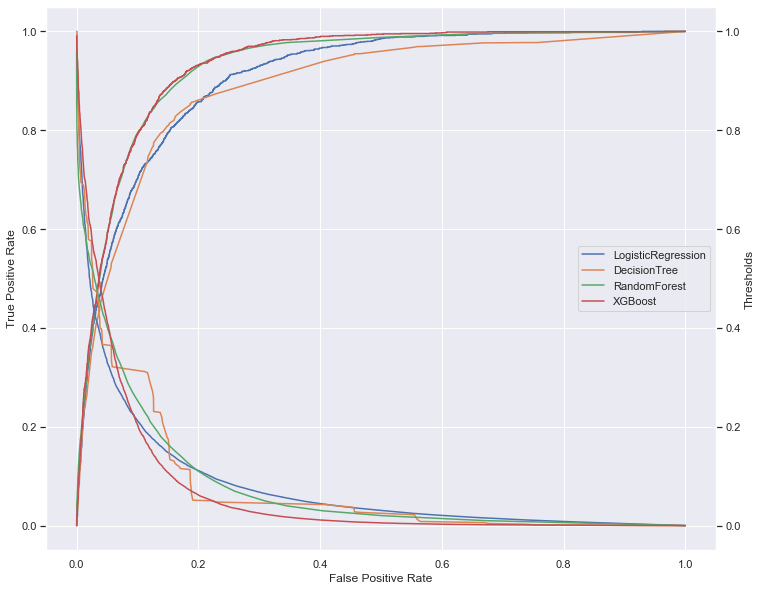

In [41]:
sns.set(style='darkgrid')
fig,ax = plt.subplots(figsize = (12,10))
ax.plot(lr_fpr,lr_tpr,label='LogisticRegression')
ax.plot(dt_fpr,dt_tpr,label='DecisionTree')
ax.plot(rf_fpr,rf_tpr,label='RandomForest')
ax.plot(xg_fpr,xg_tpr,label='XGBoost')

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.legend(loc='center right')

ax1 = ax.twinx()
ax1.plot(lr_fpr,lr_threshold,label='LogisticRegression')
ax1.plot(dt_fpr,dt_threshold,label='DecisionTree')
ax1.plot(rf_fpr,rf_threshold,label='RandomForest')
ax1.plot(xg_fpr,xg_threshold,label='XGBoost')
ax1.set_ylabel('Thresholds')
plt.grid()
plt.show()

Thus from the AUC-ROC Curve, we see that XGBoost is giving us the best results followed by Random Forest, Logistic and Decision Tree. Further, we can build ensemble models using bagging, boosting and stacking classifiers for better results.